In [2]:
# Import the essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

## creating a class

In [3]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

### Chess board calibration

no corners found
no corners found
no corners found


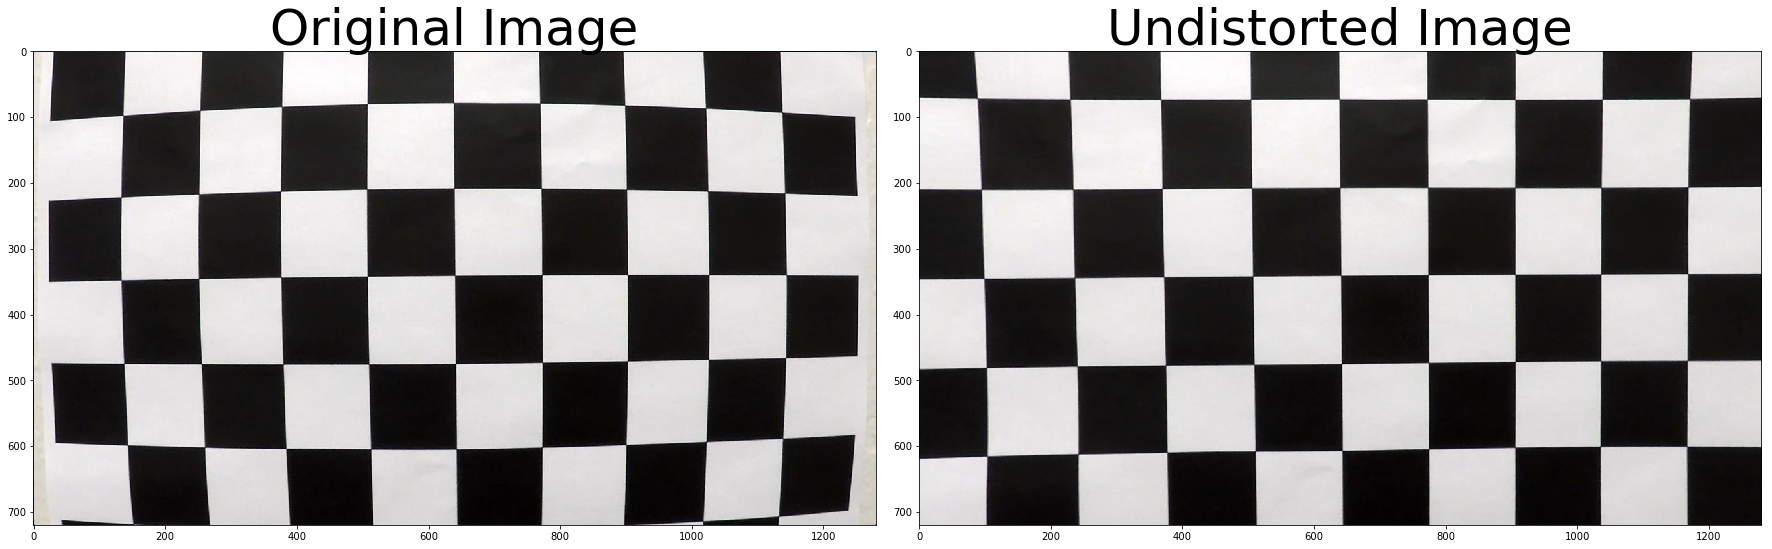

In [10]:
nx = 9
ny = 6

images = glob.glob('camera_cal/calibration*.jpg')

objpoints =[]
imgpoints =[]
    
# prepare object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        print('no corners found')

img = mpimg.imread('camera_cal/calibration1.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imsave('camera_cal_output/calibration1.jpg',dst)

def undist_img(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undisorting the camera lane images

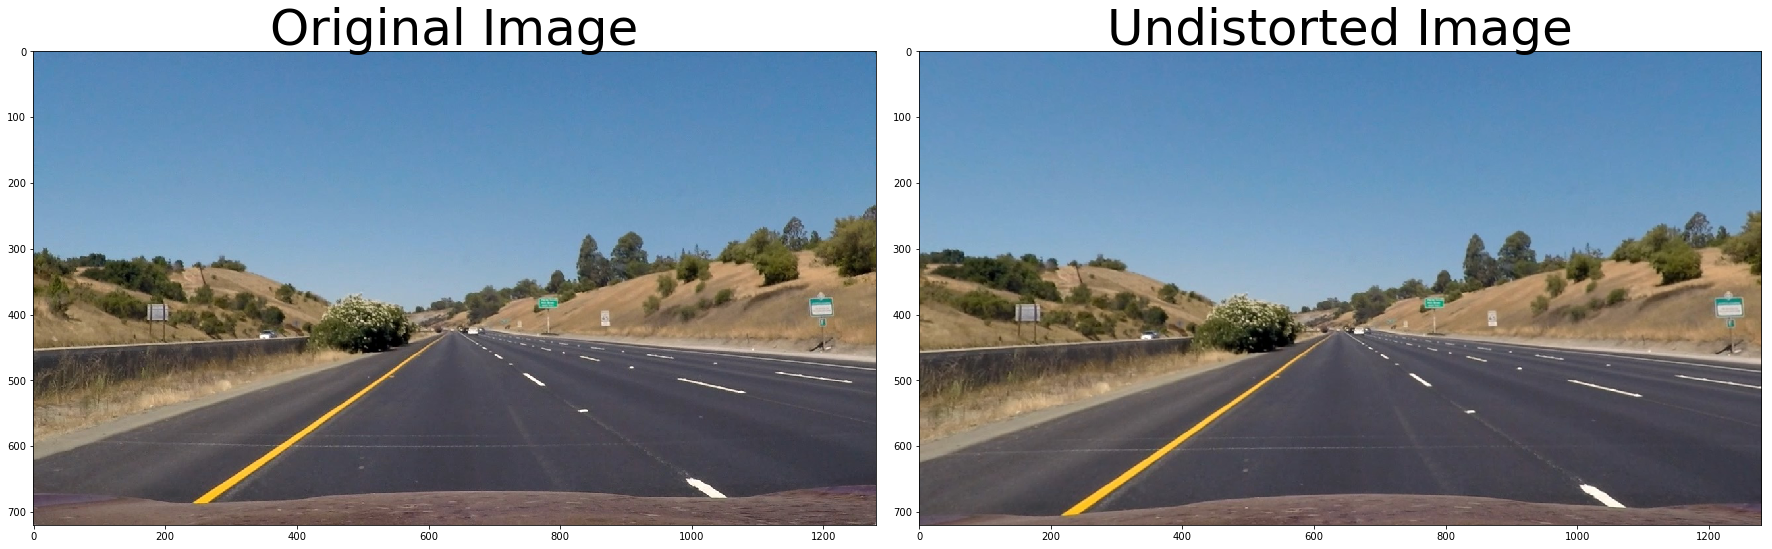

In [13]:
img = mpimg.imread('test_images/straight_lines1.jpg')
obj=Line()
dst = undist_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Applying Sobel

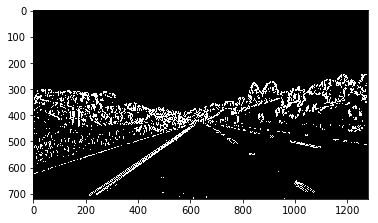

In [14]:
gray = cv2.cvtColor(dst,cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=15)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=15)
abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))


thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobelx)
sxbinary[(scaled_sobelx > thresh_min) & (scaled_sobelx < thresh_max)] = 1
sybinary = np.zeros_like(scaled_sobely)
sybinary[(scaled_sobely > thresh_min) & (scaled_sobely < thresh_max)] = 1
sbinary = np.zeros_like(scaled_sobelx)
sbinary[(sybinary==1) & (sxbinary ==1)]=1
plt.imshow(sxbinary,cmap='gray')

## applying sobel gradients magnitude threshold

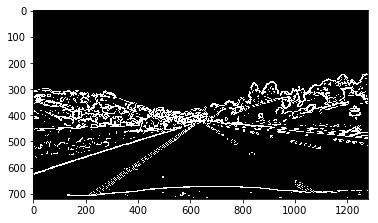

In [15]:
abs_sobelxy =np.sqrt(np.square(sobelx)+np.square(sobely))
mag_thresh_min = 30
mag_thresh_max = 100
scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
abs_sobelxybinary = np.zeros_like(sobelx)
abs_sobelxybinary[(scaled_sobelxy > mag_thresh_min) & (scaled_sobelxy < mag_thresh_max)] = 1
plt.imshow(abs_sobelxybinary,cmap='gray')

## Direction of the Gradient threshold

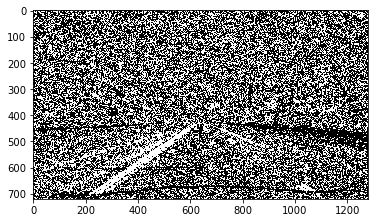

In [16]:
grad_direction = np.arctan2(abs_sobely,abs_sobelx)
dir_thresh_min = 0.7
dir_thresh_max = 1.3
grad_direction_binary = np.zeros_like(sobely)
grad_direction_binary[(grad_direction >= dir_thresh_min) & (grad_direction <= dir_thresh_max)] = 1
plt.imshow(grad_direction_binary,cmap='gray')

## Combine the thresholds and see what happens

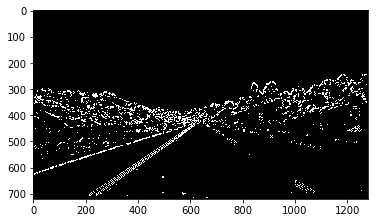

In [17]:
combined = np.zeros_like(abs_sobelxybinary)
combined[((grad_direction_binary == 1) & (abs_sobelxybinary == 1))|(sbinary==1)] = 1
plt.imshow(combined,cmap='gray')

### Looking at HLS thresholding to detect lanes

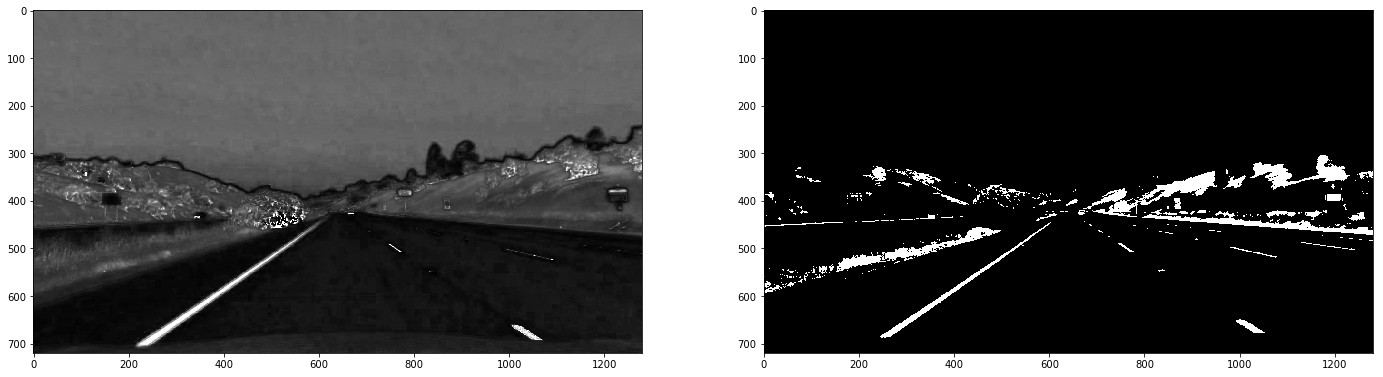

In [22]:
image = mpimg.imread('test_images/straight_lines1.jpg')
dst = cv2.undistort(image, mtx, dist, None, mtx)
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]
hls = cv2.cvtColor(dst,cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
s = hls[:,:,2]
rbinary = np.zeros_like(r)
rbinary[(r>170) & (r<=255)]=1
sbinary = np.zeros_like(s)
sbinary[(s>170) & (s<=255)]=1
hbinary = np.zeros_like(h)
hbinary[(h>20)&(h<=50)]=1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(s,cmap='gray')
ax2.imshow(rbinary,cmap='gray')

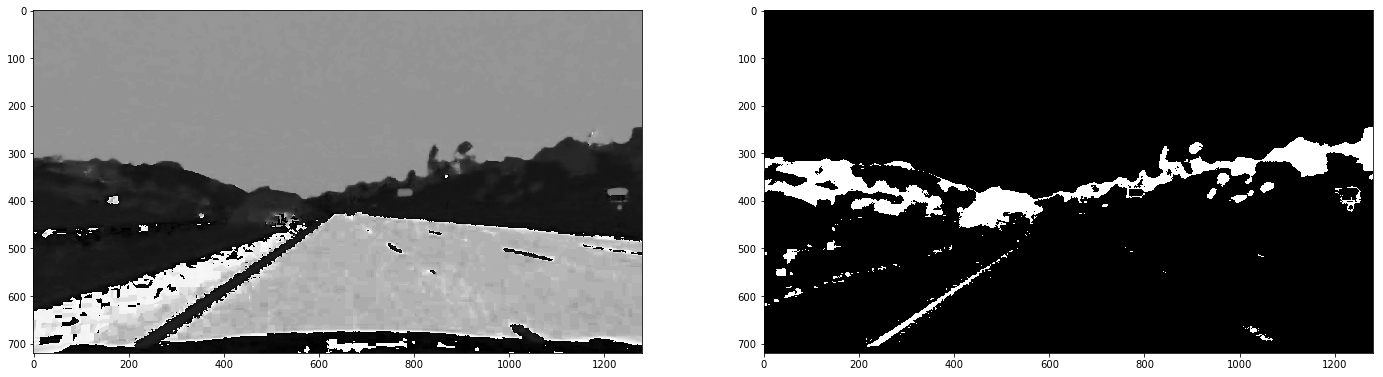

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(h,cmap='gray')
ax2.imshow(hbinary,cmap='gray')

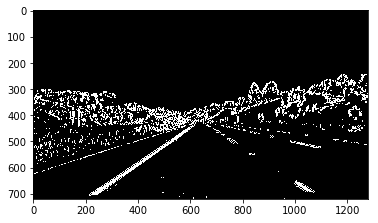

In [44]:
hsbinary = np.zeros_like(s)
hsbinary[(sxbinary==1)|(sbinary==1)]=1
plt.imshow(hsbinary,cmap='gray')
plt.imsave('test_output/hsinary.jpg',hsbinary)

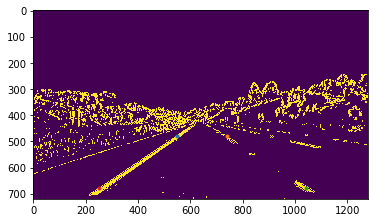

In [45]:
plt.imshow(hsbinary)
plt.plot(550,480,'.')
plt.plot(740,480,'.')
plt.plot(1042,680,'.')
plt.plot(252,680,'.')
source_vertices = np.float32([[550,480],[740,480],[1042,680],[252,680]])
dest_vertices = np.float32([[252,0],[1042,0],[1042,720],[252,720]])

## Warp perspective

[[-6.32000000e-01 -1.54648000e+00  1.05160640e+03]
 [-2.99760217e-15 -2.27520000e+00  1.09209600e+03]
 [-4.01154804e-18 -2.40000000e-03  1.00000000e+00]]


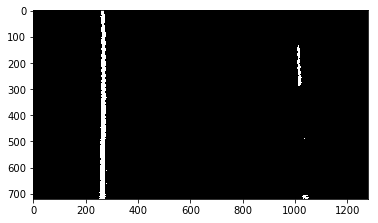

In [48]:
M = cv2.getPerspectiveTransform(source_vertices,dest_vertices)
M_inv = cv2.getPerspectiveTransform(dest_vertices,source_vertices)

img_size = (sbinary.shape[1], sbinary.shape[0])
warped = cv2.warpPerspective(sbinary, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='gray')

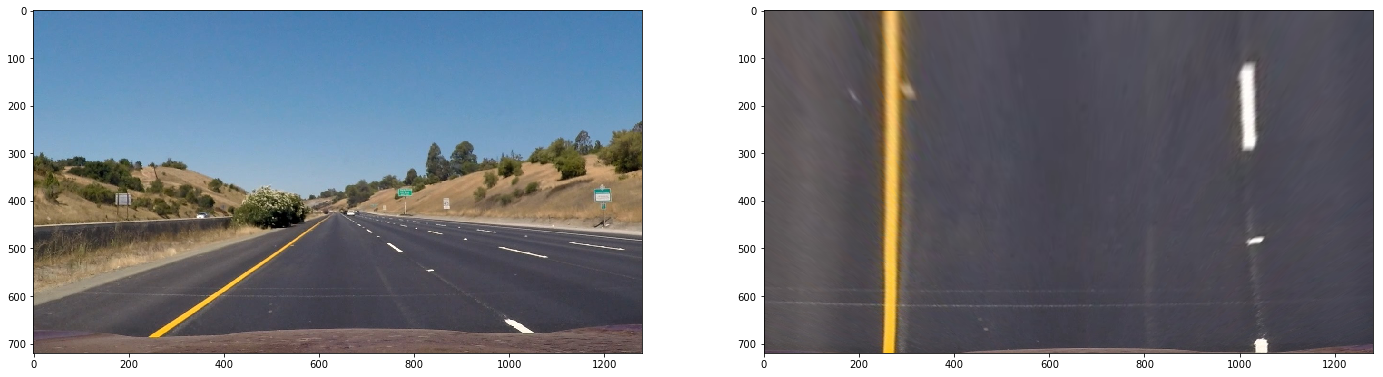

In [47]:
image = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (image.shape[1], image.shape[0])
warped_new = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(image)
ax2.imshow(warped_new)

## plotting histogram and finding the peaks

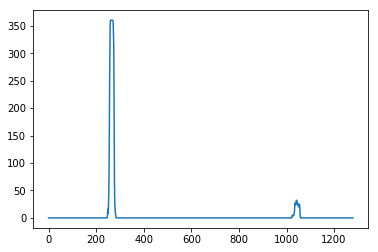

In [14]:
bottom_half=warped[warped.shape[0]//2:,:]
histogram = np.sum(bottom_half,axis=0)
plt.plot(histogram)

## Sliding Window technique

In [49]:
out_img = np.dstack((warped,warped,warped))*255
midpoint = np.int(out_img.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:])+midpoint
print(leftx_base,rightx_base)
print(midpoint)
print(rightx_base-)

260 1041
360


260 1041


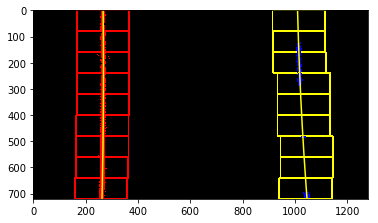

In [30]:
nwindows = 9 # number of windows
margin = 100 #width of the windows
minpix = 50 #minimum number of pixels found to recenter window
window_height = warped.shape[0]//nwindows
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
#current positions
leftx_current = leftx_base
rightx_current = rightx_base

print(leftx_base, rightx_base)
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # finding the window coordinates
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - (window)*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (255,0,0), 5)
    cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (255,255,0), 5)
    
    good_left_inds = np.nonzero((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high))[0]
    good_right_inds = np.nonzero((nonzerox<=win_xright_high)&(nonzerox>=win_xright_low)&
                                 (nonzeroy<=win_y_high)&(nonzeroy>=win_y_low))[0]
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds)>=minpix:
        leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds)>=minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.imshow(out_img)

## Searching around a polynomial instead of sliding window

[-2.34043348e-05  1.22947484e-02  2.67152479e+02]
[2.45300010e-05 2.87969210e-02 1.00870967e+03]


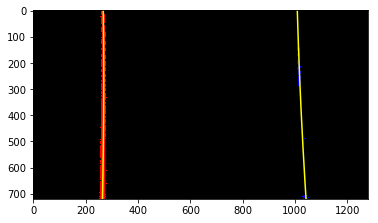

In [50]:

nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]

left_lane_inds = (nonzerox >= (left_fitx - margin)) & (nonzerox <= (left_fitx + margin))
right_lane_inds = (nonzerox >= (right_fitx - margin)) & (nonzerox <= (right_fitx + margin))

#Extract the pixel positions
leftx = nonzerox[left_lane_inds]
rightx = nonzerox[right_lane_inds]
lefty = nonzeroy[left_lane_inds]
righty= nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((warped, warped, warped))*255
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

print(left_fit)
print(right_fit)

## calculating the radius of curvature

In [51]:
y_eval=out_img.shape[0]
left_curverad = ((1 +(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
right_curverad = ((1 +(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
print(left_curverad,right_curverad)

21378.25130573686 20509.037489163446


## convert radius of curvature from pixel dimension to real world dimension

In [52]:
# Define the conversion
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#get the leftfit and right fit values in meters rather than pixels
left_fit_met = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
right_fit_met = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
print(left_fit_met)
print(right_fit_met)
left_curverad_met = ((1 +(2*left_fit_met[0]*y_eval*ym_per_pix+left_fit_met[1])**2)**1.5)/np.absolute(2*left_fit_met[0])
right_curverad_met = ((1 +(2*right_fit_met[0]*y_eval*ym_per_pix+right_fit_met[1])**2)**1.5)/np.absolute(2*right_fit_met[0])
print(left_curverad_met,right_curverad_met)

[-7.12561689e-05  1.55967665e-03  1.41209167e+00]
[7.46833401e-05 3.65309513e-03 5.33175113e+00]
7017.013951851743 6695.5980074400195


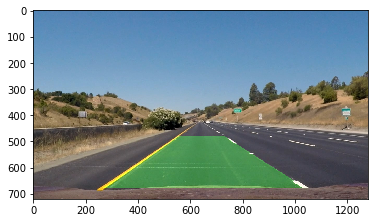

In [37]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [ ]:
# steps to do
# implement sanity checks for the lane detection